# Tarea 2: Problemas de clasificación y PCAs

Sergio Gracia Borobia

In [1]:
#Packages
library(caret)

Loading required package: lattice

Loading required package: ggplot2

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



In [2]:
# Loading data for occ 1mm
data = read.csv("meteo.csv", row.names = "X")
data$y[which(data$y < 1)] = 0
data$y[which(data$y >= 1)] = 1
data$y = as.factor(data$y)

## Punto 1: Vecinos cercanos (KNN)

Dividimos los conjuntos de *train* y *test*, con los primeros 20 años de datos para el primero, y los 10 años restantes para el segundo.

In [3]:
n = 20*365
indTrain = 1:n
indTest = setdiff(1:nrow(data), indTrain)
dfTrain = data[indTrain, ]
dfTest = data[indTest, ]

Para encontrar el valor óptimo del número de vecinos `k` realizaremos un entrenamiento con la función `train` de `caret`, realizando un control mediante un proceso de cross-validation hold-out. En primer lugar, entrenamos sin escalar los datos, y después escalándolos (argumento `preProcess`), y comparamos los resultados.

In [4]:
# Entrenamiento sin escalado
t1 = Sys.time()
ctrl = trainControl(method = "cv", number = 2)
knn = train(y ~ ., dfTrain,
                method = "knn",
                trControl = ctrl,
                preProcess = c("center"),
                tuneGrid = expand.grid(k = 1:15))
t2 = Sys.time()
t = t2-t1
t

Time difference of 6.175136 mins

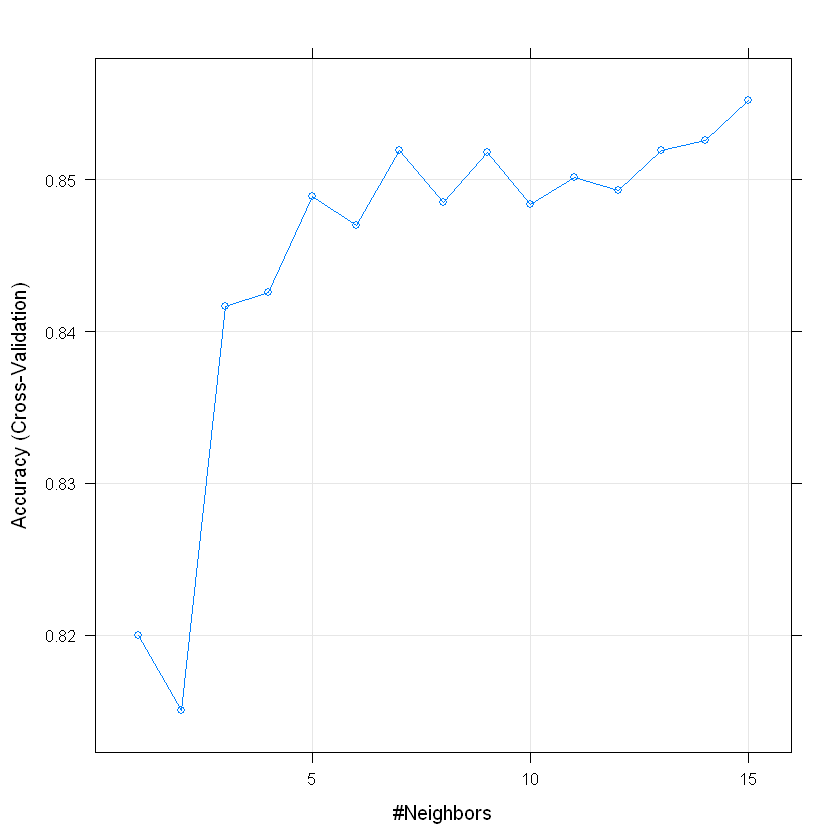

In [5]:
plot(knn)

In [6]:
knn$bestTune
knn$results$Accuracy[as.integer(knn$bestTune)]

,k
15,15


[1] 0.8552055

Ahora entrenamos el modelo normalizando los datos, mediante el parámetro `scale`.

In [7]:
# Entrenamiento con escalado
t1 = Sys.time()
ctrl = trainControl(method = "cv", number = 2)
knnScale = train(y ~ ., dfTrain,
                method = "knn",
                trControl = ctrl,
                preProcess = c("center", "scale"),
                tuneGrid = expand.grid(k = 1:15))
t2 = Sys.time()
tScale = t2-t1
tScale

Time difference of 5.962755 mins

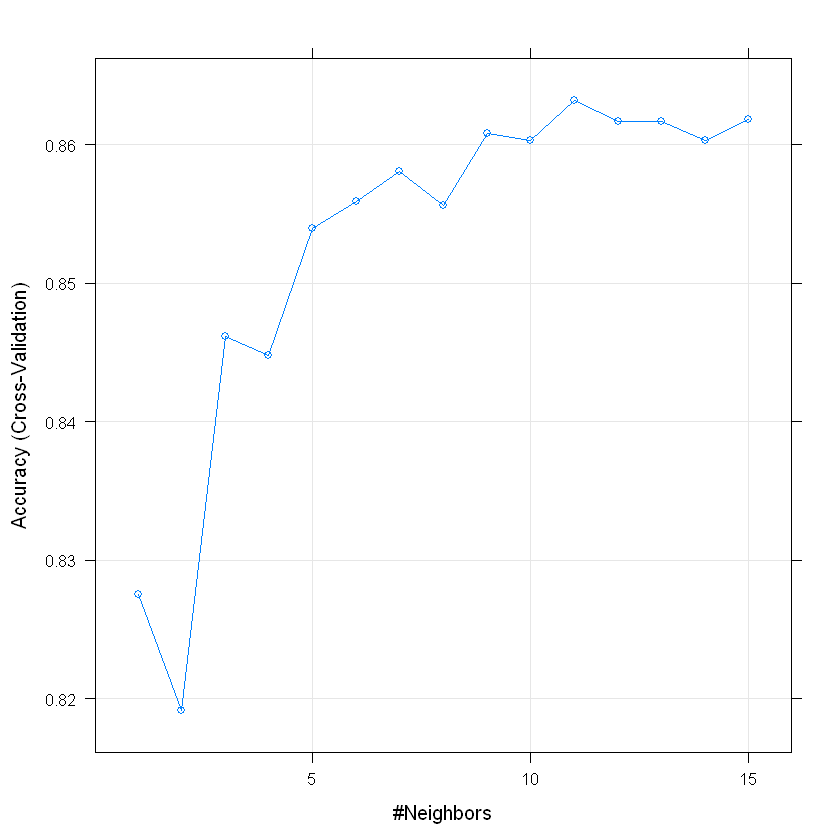

In [8]:
plot(knnScale)

In [9]:
knnScale$bestTune
knnScale$results$Accuracy[knnScale$bestTune$k]

,k
11,11


[1] 0.8631507

In [10]:
data.frame(best.k = c(knn$bestTune$k,knnScale$bestTune$k),
           accuracy = c(knn$results$Accuracy[knn$bestTune$k],
                        knnScale$results$Accuracy[knnScale$bestTune$k]),
           row.names = c("Unscaled", "Scaled")
          )

,best.k,accuracy
Unscaled,15,0.8552055
Scaled,11,0.8631507


Como podemos observar, el k optimo para los datos escalados es un poco más pequeño que para los datos sin escalar. Este hecho no tiene mayor trascendencia, ya que para diferentes ejecuciones obtenemos diferentes k óptimos, debido a que los accuracys son muy parecidos. Por otra parte, el accuracy del modelo escalado es ligeramente superior, aunque apenas se aprecia.

Aunque la diferencia en precisiones no sea demasiada, en este caso es necesario normalizar los datos porque encontramos variables que tienen magnitudes mucho más grandes (varios órdenes de magnitud) que otras, simplemente por el sistema de unidades que se utiliza en el panorama meteorológico; la presión en Pa suele ser del orden de $10^6$, mientras que la temperatura en grados centígrados (o Kelvin) se encuentra sobre las decenas o centenas.

Al utilizar el algoritmo de `knn`, que basa su clasificación en la distancia entre elementos, que se calcula haciendo uso de todos los predictores, aquellos que tengan una magnitud significativamente mayor tendrán mayor peso al calcular la distancia. Por tanto, obtenemos un modelo sesgado hacia los predictores de mayor magnitud, ya que el resto de predictores apenas influye en el proceso, y es necesario normalizar los datos.

En relación al tiempo de computación, obtenemos:

In [11]:
c(t, tScale)

Time differences in mins
[1] 6.175136 5.962755

Se aprecia como el tiempo de computación es ridículamente alto, tardando del orden de minutos en entrenar un modelo. Efectivamente, se debe a la alta dimensionalidad de los datos, con más de 300 predictores, que además en muchos casos serán redundantes. Para resolver este problema, realizaremos un proceso de reducción de la dimensionalidad mediante el método de componentes principales (PCAs).

Por último, calculamos el accuracy para la predicción sobre el conjunto de test, utilizando el modelo `knnScale` donde hemos escalado los datos por los motivos anteriormente mencionados.

In [12]:
# Función para calcular la Accuracy
accuracy = function(x, y) {
  stopifnot(length(x) == length(y))
  return(sum(diag(table(x, y))) / length(x))
}

In [13]:
pred = predict(knnScale, dfTest[, -1])
accuracy(pred, dfTest$y)

[1] 0.8605796

Podemos observar que al predecir sobre el conjunto de test obtenemos un accuracy ligeramente menor con respecto al conjunto de train, pero no supone una diferencia significativa, por lo que consideramos un modelo bien entrenado.

## Punto 2: PCAs para 1mm

En este apartado, realizaremos una reducción de la dimensionalidad por medio del método de componentes principales, o PCAs. Para ello, tomaremos como predictando los días de lluvia (cuando la precipitación es mayor de 1mm).

Nuevamente, dividimos los conjuntos de train y de test:

In [14]:
n = 20*365
indTrain = 1:n
indTest = setdiff(1:nrow(data), indTrain)
dfTrain = data[indTrain, ]
dfTest = data[indTest, ]

Calculamos las componentes principales utilizando la función `prcomp`, a la que le especificamos que los datos estén centrados (media nula) y escalados. En este caso también es importante normalizar los datos, porque nuevamente los predictores de mayor magnitud crean un sesgo en la varianza. De hecho, si multiplicamos un conjunto de datos cualquiera por una constante, su varianza aumenta como dicha constante al cuadrado, por lo que el sesgo es más notable aún.

In [15]:
PCA = prcomp(dfTrain[,-1], center=TRUE, scale=TRUE)
PCAtest = prcomp(dfTest[,-1], center=TRUE, scale=TRUE) # Para predecir después

Calculamos la varianza explicada como la suma cumulativa de las varianzas obtenidas en las PCAs:

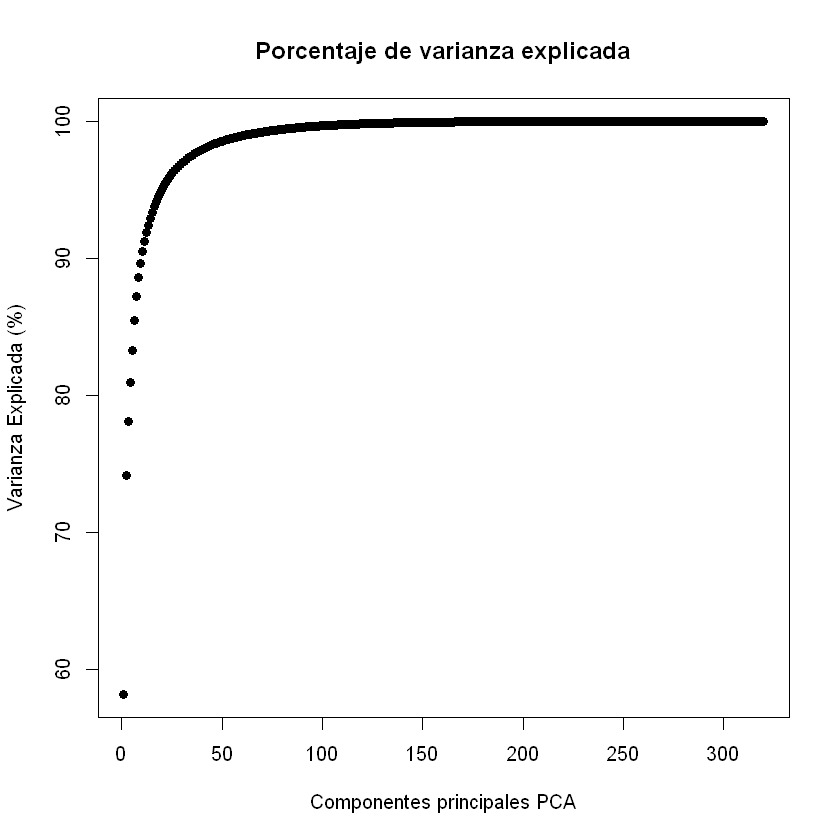

In [16]:
expVar = cumsum(PCA$sdev^2)/sum(PCA$sdev^2) * 100
plot(expVar, cex = 1, pch = 16,
     xlab = "Componentes principales PCA", ylab= "Varianza Explicada (%)",
     main = "Porcentaje de varianza explicada")

Como podemos observar, para un número bastante pequeño de PCAs (cerca de la decena), ya obtenemos más de un 90% de la varianza explicada, por lo que podemos entrenar un modelo con muchas menos variables de las que estábamos utilizando en el apartado anterior. El número de variables dependerá del porcentaje de varianza explicada que escojamos, de manera que comprobamos cómo se comporta el modelo para varios porcentajes:

In [17]:
thold = seq(60,90,10)
kfit = c()
kAcc = c()
n = c()
time = c()
for(t in thold){
    y = data.frame(y = dfTrain$y)
    dfPCA = cbind(y, PCA$x[, which(expVar<t)])
    # KNN
    t1 = Sys.time()
    knnPCA= train(y ~ ., dfPCA,
                method = "knn",
                preProcess = c("center", "scale"),
                tuneGrid = expand.grid(k = 1:15))
    
    # Escogemos 80% para el próximo apartado
    if(t == 80){
        knn80 = knnPCA
    }
    
    t2 = Sys.time()
    time = c(time, t2-t1)
    n = c(n, max(which(expVar<t)))
    kfit = c(kfit, knnPCA$bestTune$k)
    kAcc = c(kAcc, knnPCA$results$Accuracy[as.integer(knnPCA$bestTune)])
}
results = data.frame(expVar = thold, ncomp = n, kfit = kfit, kAcc = kAcc, time = time)
results

expVar,ncomp,kfit,kAcc,time
60,1,15,0.7650655,27.910342
70,1,15,0.7631851,27.271196
80,3,15,0.8317817,35.758125
90,9,15,0.8564422,1.052439


Como podemos observar, el tiempo de entrenamiento del modelo se reduce enormemente, del orden de segundos, mantienendo accuracys similares al utilizar únicamente 3 o 9 variables, en comparación con el apartado anterior donde entrenábamos el modelo con todos los predictores. 

Elegimos una varianza explicada del 80%. Como podemos apreciar, al tomar el 90% el entrenamiento del modelo tarda cerca del doble de tiempo y apenas mejora la precisión. Por este motivo, utilizaremos únicamente tres componentes principales.

Con esta configuración óptima, predecimos sobre el conjunto de test:

In [18]:
dfPCAtest80 = PCAtest$x[, which(expVar<80)]
pred1 = predict(knn80, dfPCAtest80)
accuracy(pred1, dfTest$y)

[1] 0.7077638

Obtenemos una accuracy inferior comparada con la obtenida para el conjunto de train, pero se encuentra dentro del rango de valores considerados aceptables.

## Punto 3: PCAs para 20mm

En este apartado, repetimos lo realizado en el apartado 2, pero tomando como predictando las precipitaciones intensas, es decir, aquellas mayores de 20mm. 

In [19]:
# Lectura de datos
data20 = read.csv("meteo.csv", row.names = "X")
data20$y[which(data20$y < 20)] = 0
data20$y[which(data20$y >= 20)] = 1
data20$y = as.factor(data20$y)

In [20]:
n = 20*365
indTrain = 1:n
indTest = setdiff(1:nrow(data20), indTrain)
dfTrain20 = data20[indTrain, ]
dfTest20 = data20[indTest, ]

In [21]:
PCA20 = prcomp(dfTrain20[,-1], center=TRUE, scale=TRUE)

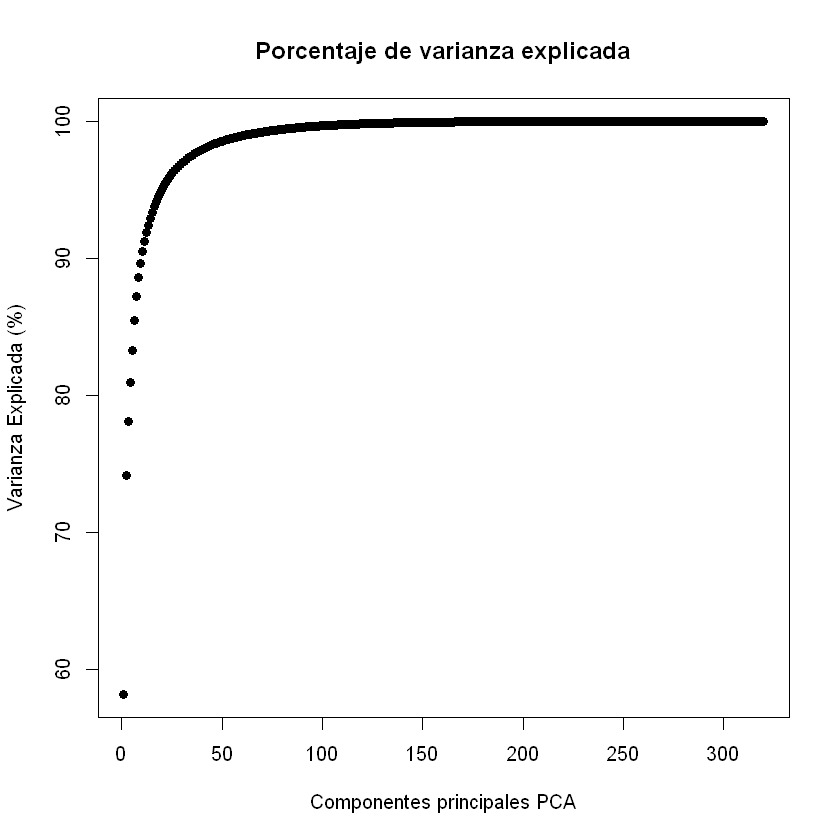

In [22]:
expVar20 = cumsum(PCA20$sdev^2)/sum(PCA20$sdev^2) * 100
plot(expVar20, cex = 1, pch = 16,
     xlab = "Componentes principales PCA", ylab= "Varianza Explicada (%)",
     main = "Porcentaje de varianza explicada")

Al representar la varianza explicada, obtenemos exactamente la misma gráfica que en el apartado anterior. Esto se debe a que en el proceso de obtención de las PCA únicamente intervienen los predictores, que son los mismos para ambos datasets.

Nuevamente, estudiamos la precisión del método knn para diferentes porcentajes de varianza explicada:

In [23]:
thold = seq(60,90,10)
n = c()
kfit = c()
kAcc = c()
time = c()
for(t in thold){
    y = data.frame(y = dfTrain20$y)
    dfPCA = cbind(y, PCA20$x[, which(expVar20<t)])
    # KNN
    t1 = Sys.time()
    knnPCA = train(y ~ ., dfPCA,
                method = "knn",
                preProcess = c("center", "scale"),
                tuneGrid = expand.grid(k = 1:15))
    
    # Escogemos 80% para el próximo apartado
    if(t == 80){
        knn80.20 = knnPCA
    }
    
    t2 = Sys.time()
    time = c(time, t2-t1)
    n = c(n, max(which(expVar20<t)))
    kfit = c(kfit, knnPCA$bestTune$k)
    kAcc = c(kAcc, knnPCA$results$Accuracy[as.integer(knnPCA$bestTune)])
}
results20 = data.frame(expVar = thold, ncomp = n, kfit = kfit, kAcc = kAcc, time = time)
results20

expVar,ncomp,kfit,kAcc,time
60,1,15,0.9736472,27.621276
70,1,15,0.9741950,26.932119
80,3,15,0.9728704,35.578083
90,9,15,0.9744177,1.041437


Con respecto a los tiempos de computación, obtenemos resultados similares. Sin embargo, para las accuracys obtenidas, obtenemos valores notablemente más altos, obteniendo modelos que predicen casi a la perfección. Estudiando también la predicción sobre el conjunto de test:

In [24]:
dfPCAtest80 = PCAtest$x[, which(expVar<80)]
pred20 = predict(knn80.20, dfPCAtest80)
accuracy(pred20, dfTest$y)

[1] 0.8042646

Obtenemos un accuracy menor que para el conjunto de train, pero superior al accuracy obtenido para el conjunto de test en el apartado anterior. Podemos concluir entonces que, en este caso y dado que las lluvias intensas son menos frecuentes, el modelo consigue predecir con una mejoría significativa.

## Punto 4: Comparación con regresión logística

In [25]:
# Construcción de Dataframes
datT1 = data.frame(y = dfTrain$y, PCA$x[, which(expVar<80)])
datT20 = data.frame(y = dfTrain20$y, PCA$x[, which(expVar<80)])
PCAtest = prcomp(dfTest[,-1], center=TRUE, scale=TRUE)
datt1 = data.frame(y = dfTest$y, PCAtest$x[, which(expVar<80)])
datt20 = data.frame(y = dfTest20$y , PCAtest$x[, which(expVar<80)])
# Regresión logística
reg1 = glm(datT1$y~., data = datT1, family = binomial(link = "logit"))
reg20 = glm(datT20$y~., data = datT20, family = binomial(link = "logit"))
# Predicción sobre el test
pred.reg1 = predict(object = reg1, newdata = datt1)
pred.reg20 = predict(object = reg20, newdata = datt20)
# Caracter binario de la ocurrencia
pred.reg1 = ifelse(pred.reg1 >= 0.5, 1, 0)
pred.reg20 = ifelse(pred.reg20 >= 0.1, 1, 0)

In [29]:
library("AUC")
roc.reg1 = roc(pred.reg1, dfTest$y)
roc.reg20 = roc(pred.reg20, dfTest20$y)
roc.knn1 = roc(pred1, dfTest$y)
roc.knn20 = roc(pred20, dfTest$y)

[1] 0.4710922

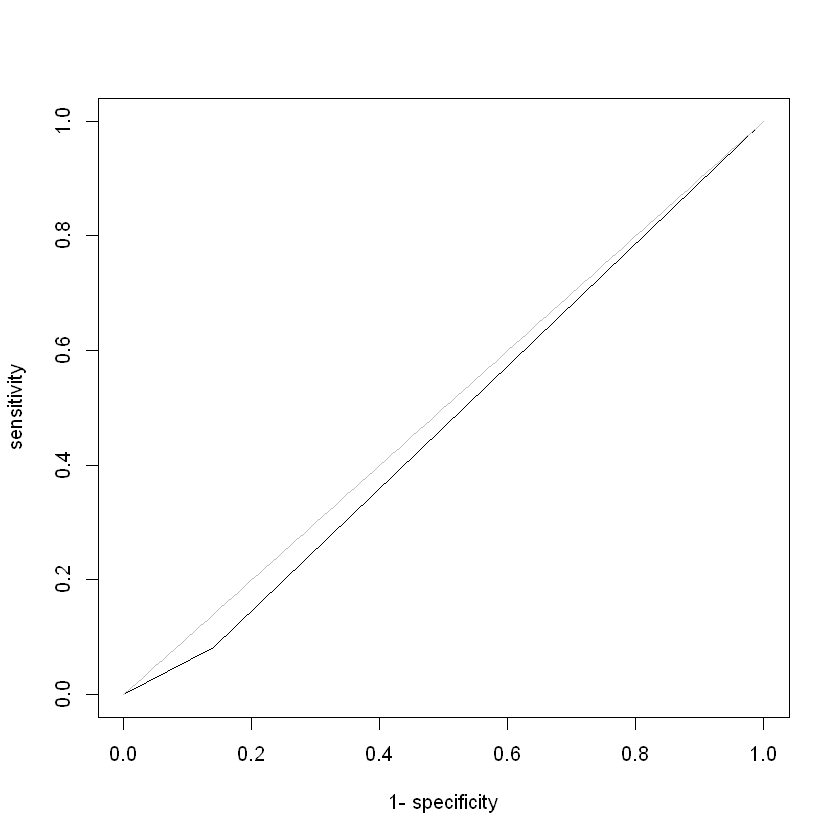

[1] 0.4998301

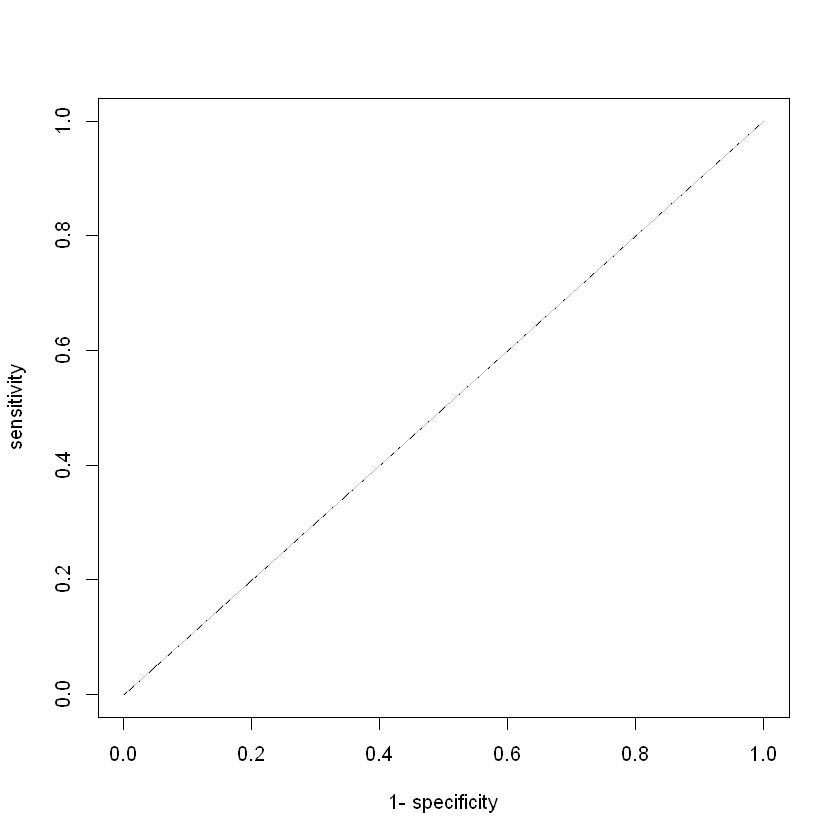

[1] 0.4973318

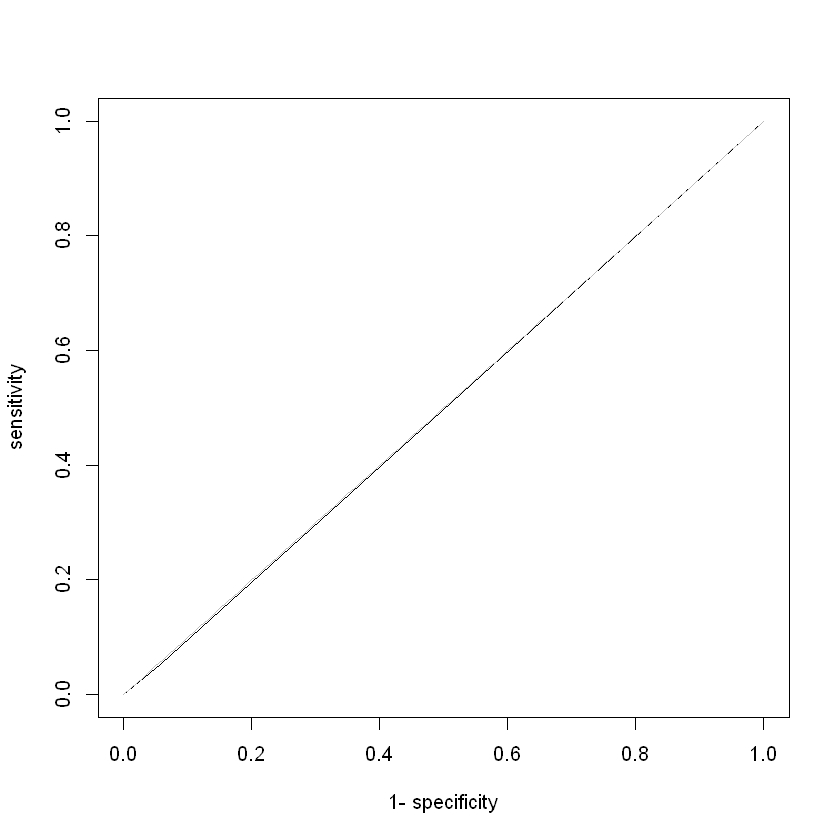

[1] 0.5

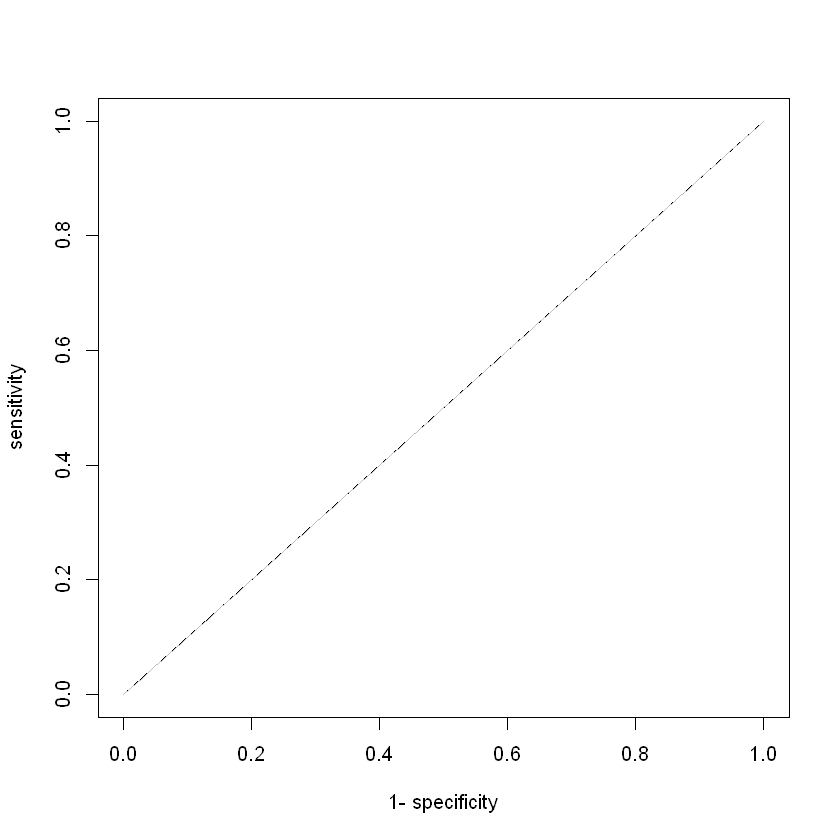

In [31]:
plot(roc.knn1)
auc(roc.knn1)
plot(roc.knn20)
auc(roc.knn20)
plot(roc.reg1)
auc(roc.reg1)
plot(roc.reg20)
auc(roc.reg20)

Lamentablemente, estos resultados no tienen sentido. Por falta de tiempo me resulta imposible localizar el error. 